In [1]:
### General imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

### --- Figure config
LEGEND_SIZE = 15



In [2]:
from emukit.test_functions import forrester_function
from emukit.core.loop.user_function import UserFunctionWrapper
from emukit.core import ContinuousParameter, ParameterSpace


#space是否设置为一维线性，还是设置为搜索空间？

# 测试获取函数

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

# import emukit
import GPy
# from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
# from emukit.core.initial_designs.random_design import RandomDesign
# from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

# from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
# from emukit.core.acquisition import IntegratedHyperParameterAcquisition

# from rgpe import compute_rank_weights

In [4]:
def find_y_by_x(x_input, X_all, Y_all):  #一通过x找到对应的y的函数
    # 确保 x_input 是一个二维数组
    if len(x_input.shape) == 1:
        x_input = x_input.reshape(1, -1)

    # 初始化一个列表来存储所有结果
    all_results = []

    # 遍历 x_input 中的每个特征向量
    for x in x_input:
        # 使用 NumPy 的函数 argwhere 来查找 x 在 X 中的位置
        indices = np.argwhere(np.all(X_all == x, axis=1))

        # 初始化一个列表来存储匹配的 Y 值
        matching_y_values = []

        # 遍历匹配的位置
        for index in indices:
            match_index = index[0]
            matching_y_values.append(Y_all[match_index])

        all_results.append(matching_y_values)
    
    all_results = np.array(all_results)
    return all_results



# SE代码

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

In [6]:
def x_normalizer(X, var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
            
    return x_norm

def x_denormalizer(x_norm, var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
            
    return x_original


import numpy as np
from scipy.spatial.distance import cdist


def get_closest_array(x_init, X_all):
    # 计算 x_init 中每个点与 X_all 中所有点之间的距离
    distances = cdist(x_init, X_all)   
    # 找到每个点最近的索引
    closest_indices = np.argmin(distances, axis=1)    
    # 根据索引获取最近的点
    closest_array = X_all[closest_indices]  
    return closest_array

In [7]:
def calculate_distances(X):
    # 计算每个向量与自己的欧氏距离
    self_distances = np.linalg.norm(X[:, np.newaxis, :] - X, axis=-1)
    # 将对角线上的距离设置为无穷大，排除自身与自身的距离
    np.fill_diagonal(self_distances, np.inf)
    # 计算除了自己之外的其他向量与每个向量的欧氏距离
    other_distances = np.min(self_distances, axis=1)
    # 将结果转换为二维数组
    other_distances = other_distances.reshape(-1, 1)
    # 计算均值
    mean_distance = np.mean(other_distances)
    return mean_distance

def create_latin_design(X_all):
 
    x_array = [X_all[:, i] for i in range(X_all.shape[1])]
    
    num_columns = X_all.shape[1]
    parameter_space = ParameterSpace([ContinuousParameter(f'x{i+1}', 0, 1) for i in range(num_columns)])
    design = LatinDesign(parameter_space)
    
    return x_array , design


def calculate_hv(X):
    max_values = np.max(X, axis=0)
    min_values = np.min(X, axis=0) 
    # 计算每个维度的范围（最大值 - 最小值）
    ranges = max_values - min_values  
    # 计算所有维度范围的乘积，得到面积
    area = np.prod(ranges)
    return area

def find_min_point_in_a_dimension(X):
    # 随机选取一列
    random_col_index = np.random.randint(0, X.shape[1])
    
    # 找到该列的最小值
    min_value_index = np.argmin(X[:, random_col_index])
    
    # 找到该最小值对应的整行元素
    min_x = X[min_value_index].reshape(1, -1)
    
    return min_x





In [8]:
import numpy as np

def evaluate_all(X: np.ndarray, X_all: np.ndarray) -> np.ndarray:
    # 扩展 X_all 维度以便进行广播
    X_all_expanded = X_all[:, np.newaxis, :]
    # 扩展 X 维度以便进行广播
    X_expanded = X[np.newaxis, :, :]
    # 计算欧氏距离矩阵
    Euclidean_distance = np.linalg.norm(X_all_expanded - X_expanded, axis=-1)
    # 获取最小距离
    min_distance = np.min(Euclidean_distance, axis=1)
    
    return min_distance.reshape(-1, 1)

def SE_samples(X: np.ndarray, X_all: np.ndarray, batch_size) -> np.ndarray:
    for _ in range(batch_size):
        all_Edis = evaluate_all(X, X_all)
        
        for x_row in X:
            indices = np.where(np.all(X_all == x_row, axis=-1))[0]
            all_Edis[indices] = 0
        
        sort_index = np.argsort(all_Edis, axis=0).flatten()
        x_new = X_all[sort_index[-1]]
        
        X = np.append(X, [x_new], axis=0)
    
    return X

In [9]:
# import inspect
# se_path = inspect.getfile(SampleMinEuclideanDistance)
# print(se_path)

# 进行迭代预测

In [10]:
import pandas as pd
import os

# folder_path = r'C:\Users\13282\Desktop\papercode\data\Goldstein' 
# file_path = os.path.join(folder_path, 'goldstein_data.xlsx')
# df = pd.read_excel(file_path)

# x_all = df.iloc[:, :-1].values  
# y_all = df.iloc[:, -1].values

# folder_path = r'C:\Users\13282\Desktop\papercode\data\Aryl\original_processed' 
# file_path = os.path.join(folder_path, 'aryl-15.xlsx')  # y 记得加负号 
# 'aryl-1.xlsx'   'all_data.xlsx'  'aryl-9.xlsx' 


folder_path = r'C:\Users\13282\Desktop\papercode\data\Alloy\original_processed' 
file_path = os.path.join(folder_path, 'S1_scaled.xlsx')  # y 记得加负号 ，如果需要原始值，需要反log回去

# folder_path = r'C:\Users\13282\Desktop\papercode\data\Alloy\matminner_processed' 
# file_path = os.path.join(folder_path, 's1_data.xlsx')  # y 记得加负号 ，如果需要原始值，需要反log回去
# Ti  Virtual_ti  s1_data  s1+s2_data
# folder_path = r'C:\Users\13282\Desktop\papercode\data\Alloy\no_comp' 
# file_path = os.path.join(folder_path, 'Ni.xlsx')  # y 记得加负号 ，如果需要原始值，需要反log回去

df = pd.read_excel(file_path)

x_all = df.iloc[:, :-1].values  
y_all = - df.iloc[:, -1].values

nan_indices = np.isnan(y_all)
true_indices = np.where(nan_indices)[0]
print("nan 的索引:", true_indices)

x_all = x_all[~nan_indices.flatten()]
y_all = y_all[~nan_indices.flatten()]

print(x_all.shape,y_all.shape)

print(np.min(y_all))

nan 的索引: []
(747, 9) (747,)
-11.92857849946588


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=43)

X_all, Y_all = [X_train, Y_train.reshape(-1)]

Y_test = Y_test.reshape(-1, 1)

print(X_all.shape,Y_all.shape)
print(X_test.shape,Y_test.shape)

var_array , design = create_latin_design(X_all)

(597, 9) (597,)
(150, 9) (150, 1)


# 选择获取函数，开始迭代

In [23]:
from functools import partial
from emukit.bayesian_optimization.acquisitions import MaxValueEntropySearch

from emukit.bayesian_optimization.acquisitions import NegativeLowerConfidenceBound, ExpectedImprovement

from emukit.bayesian_optimization.acquisitions import SampleMaxVariance, SampleMinEuclideanDistance


acquisition_select = partial(SampleMinEuclideanDistance)

file_name = "SE"

# "RDM"  "MES"  "NLCB"  "EI"   "SV"   "SE"  

# acquisition_select = partial(NegativeLowerConfidenceBound, beta=2.0)

# ei_acquisition = NegativeLowerConfidenceBound(emukit_model, beta=2.0)

# es_acquisition = EntropySearch(emukit_model,space)
# mes_acquisition = MaxValueEntropySearch(emukit_model,space)
                       

n_loop = 40  # s2_data：60

maxiter = 30    # s2_data：14
num_x_init = 3

model_var = 0.1
num_restarts = 5

batch_size = 2


In [24]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from scipy.stats import spearmanr
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
import tqdm

import logging
logging.getLogger('variance').setLevel(logging.ERROR)
logging.getLogger('lengthscale').setLevel(logging.ERROR)


# df_reg= pd.DataFrame()

df_rmse= pd.DataFrame()
df_mae= pd.DataFrame()
df_spearman= pd.DataFrame()
df_rsquared= pd.DataFrame()

df_meanED = pd.DataFrame()
df_hv = pd.DataFrame()

for tri in tqdm.tqdm(range(n_loop), desc="Loop Progress"): 
    
    X_train, X_test, Y_train, Y_test = train_test_split(x_all, y_all, test_size=0.2)
    X_all, Y_all = [X_train, Y_train.reshape(-1)]
    Y_test = Y_test.reshape(-1, 1)
    var_array , design = create_latin_design(X_all)
    
    rmse_list = []
    mae_list = []
    spearman_list = []
    rsquared_list = []
     
    meanED_all = []
    hv_all = []
    
# lhs 采样   
#     x_init = design.get_samples(num_x_init)                        
#     x_init_original = get_closest_array(x_denormalizer(x_init, var_array),X_all)
#     X = x_init_original
# rdm 采样   
    random_indices = np.random.choice(X_all.shape[0], num_x_init, replace=False)
    X = X_all[random_indices]
# 最小值 采样 1 个
#     X = find_min_point_in_a_dimension(X_all)
    
    Y = find_y_by_x(X, X_all, Y_all)


    # 初始化模型
    input_dim = len(X[0])

    ker = GPy.kern.Matern52(input_dim = input_dim, ARD = True)#
    
    ker.lengthscale.constrain_bounded(0.01, 10) #lengthscale决定着点与点之间的相互作用程度
    ker.variance.constrain_bounded(1e-2, 10000.0) #方差

    model_gpy = GPRegression(X,Y, ker)

    model_gpy.Gaussian_noise.variance =  model_var**2
    model_gpy.Gaussian_noise.variance.fix()

    model_gpy.randomize()
    model_gpy.optimize_restarts(num_restarts=num_restarts,verbose =False, messages=False)
    emukit_model = GPyModelWrapper(model_gpy)
    
# 第一次评估
    f_obj = emukit_model.model.predict
    y_pred, y_uncer = f_obj(X_test)
    y_pred = -y_pred[:, -1]
    y_uncer = np.sqrt(y_uncer[:, -1])
    y_truth = -Y_test[:, -1]

    rmse_value_new = np.sqrt(mean_squared_error(y_truth, y_pred))
    mae_value_new = mean_absolute_error(y_truth, y_pred)
    spearman_value_new = spearmanr(y_truth, y_pred)[0]
    rsquared_value_new = r2_score(y_truth, y_pred)

    rmse_list.append(rmse_value_new)
    mae_list.append(mae_value_new)
    spearman_list.append(spearman_value_new)
    rsquared_list.append(rsquared_value_new)

#     meanED = calculate_distances(X)
#     meanED_all.append(meanED)
    
#     hv = calculate_hv(X)
#     hv_all.append(hv)
            
    
    
    for i in range(maxiter):
        
        
#         select_acquisition = acquisition_select(emukit_model)  
        
#         acq_plot = select_acquisition.evaluate(X_all)
#         select_acquisition_nom = (acq_plot - np.min(acq_plot)) / (np.max(acq_plot) - np.min(acq_plot))

# #将已经采样点的获取函数值设为0

#         for x_row in X:
#             # 找到 x_row 在 X_all 中的位置索引
#             indices = np.where(np.all(X_all == x_row, axis=1))[0]

#             # 将对应位置上的 acq_plot 元素设置为 0
#             select_acquisition_nom[indices] = 0


#         sort_index = np.argsort(select_acquisition_nom, axis =0)

#         x_new = []
#         for i in sort_index[-top:]:
#                 x_new.append(X_all[i][0])
                
#         x_new=np.array(x_new)
#         y_new = find_y_by_x(x_new, X_all, Y_all)
        
             
        
#         X = np.append(X, x_new, axis=0)
#         Y = np.append(Y, y_new, axis=0)


        # 找到 X 在 X_all 中的索引
        indices = np.all(X_all == X[:, None, :], axis=2)
        index_to_remove = np.any(indices, axis=0)

        # 生成 x_remain，包含 X_all 中除了 X 以外的元素
        x_remain = X_all[~index_to_remove]
        
        X = SE_samples(X, x_remain, batch_size=batch_size)
        Y = find_y_by_x(X, X_all, Y_all)

        
        
#         model_gpy = GPRegression(X, Y, ker)
# #         model_gpy.optimize_restarts(num_restarts=num_restarts,verbose =False, messages=False)
#         emukit_model = GPyModelWrapper(model_gpy)
       
#         num_x = X.shape[0]
#         # 每5次取点后评估一次指标
# #         if (num_x-3) % 5 == 0 :
#         if num_x - 3 >= 0:
#             # 计算测试集指标
# #             print(X.shape)
            
        model_gpy = GPRegression(X, Y, ker)
        model_gpy.optimize_restarts(num_restarts=num_restarts,verbose =False, messages=False)
        emukit_model = GPyModelWrapper(model_gpy)

        f_obj = emukit_model.model.predict
        y_pred, y_uncer = f_obj(X_test)
        y_pred = -y_pred[:, -1]
        y_uncer = np.sqrt(y_uncer[:, -1])
        y_truth = -Y_test[:, -1]

        # 计算新的指标
        rmse_value_new = np.sqrt(mean_squared_error(y_truth, y_pred))
        mae_value_new = mean_absolute_error(y_truth, y_pred)
        spearman_value_new = spearmanr(y_truth, y_pred)[0]
        rsquared_value_new = r2_score(y_truth, y_pred)

        # 将新指标存储在列表中
        rmse_list.append(rmse_value_new)
        mae_list.append(mae_value_new)
        spearman_list.append(spearman_value_new)
        rsquared_list.append(rsquared_value_new)

        # 计算欧氏距离指标
        meanED = calculate_distances(X)
        meanED_all.append(meanED)
        hv = calculate_hv(X)
        hv_all.append(hv)
        
    
    df_rmse = pd.concat([df_rmse, pd.DataFrame([rmse_list])], ignore_index=True)
    df_mae = pd.concat([df_mae, pd.DataFrame([mae_list])], ignore_index=True)
    df_spearman = pd.concat([df_spearman, pd.DataFrame([spearman_list])], ignore_index=True)
    df_rsquared = pd.concat([df_rsquared, pd.DataFrame([rsquared_list])], ignore_index=True)

    df_meanED = pd.concat([df_meanED, pd.DataFrame([meanED_all])], ignore_index=True)
    df_hv = pd.concat([df_hv, pd.DataFrame([hv_all])], ignore_index=True)


# column_means_reg = df_reg.mean()
# new_row_reg = pd.DataFrame([column_means_reg])
# df_reg = pd.concat([df_reg, new_row_reg], ignore_index=True)
    
    


   

Loop Progress: 100%|██████████| 40/40 [13:28<00:00, 20.21s/it]


In [25]:
print(X.shape,df_spearman.shape)

(63, 9) (40, 31)


# 测试集指标

In [26]:
# reg_mean = df_reg.mean()

rmse_mean = df_rmse.mean()
mae_mean = df_mae.mean()
spearman_mean = df_spearman.mean()
rsquared_mean = df_hv.mean()



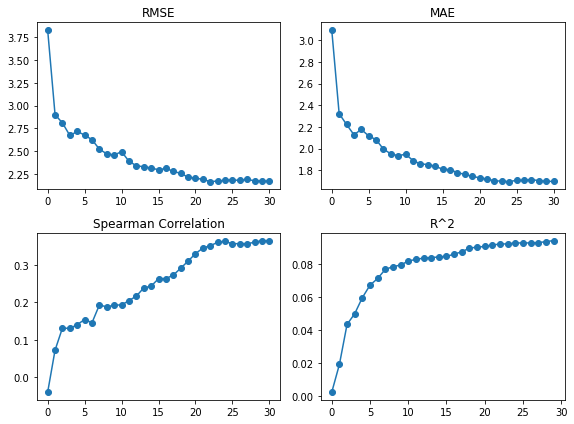

Last Test Set Metrics:
MAE: 1.7   RMSE: 2.18   spearman: 0.364   R² score: 0.094


In [27]:
# 创建一个2x2的子图布局
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# 创建自定义横坐标刻度
x_values = np.arange(len(rmse_list))

# 绘制RMSE折线图
axes[0, 0].plot(x_values, rmse_mean, label='RMSE', marker='o')
axes[0, 0].set_title('RMSE')
# axes[0, 0].set_xticks(x_values)

# 绘制MAE折线图
axes[0, 1].plot(x_values, mae_mean, label='MAE', marker='o')
axes[0, 1].set_title('MAE')

# 绘制Spearman相关系数折线图
axes[1, 0].plot(spearman_mean, label='Spearman', marker='o')
axes[1, 0].set_title('Spearman Correlation')

# 绘制R^2折线图
axes[1, 1].plot(rsquared_mean, label='R^2', marker='o')
axes[1, 1].set_title('R^2')

# 设置子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()


print('Last Test Set Metrics:')
print('MAE:', np.round(mae_mean.iloc[-1], 2), ' ',
      'RMSE:', np.round(rmse_mean.iloc[-1], 2), ' ',
      'spearman:', np.round(spearman_mean.iloc[-1], 3), ' ',
      'R² score:', np.round(rsquared_mean.iloc[-1], 3))



# 保存文件

In [28]:
import os

folder_name = 'result'

# 确保文件夹存在，如果不存在则创建
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# 构建完整的文件路径，包括文件夹名称和文件名
rmse_name = os.path.join(folder_name, f'{file_name}_rmse.xlsx')
df_rmse.to_excel(rmse_name, index=False, engine='openpyxl')

# 构建完整的文件路径，包括文件夹名称和文件名
mae_name = os.path.join(folder_name, f'{file_name}_mae.xlsx')
spearman_name = os.path.join(folder_name, f'{file_name}_spearman.xlsx')
rsquared_name = os.path.join(folder_name, f'{file_name}_rsquared.xlsx')

# 将数据保存到 Excel 文件
df_mae.to_excel(mae_name, index=False, engine='openpyxl')
df_spearman.to_excel(spearman_name, index=False, engine='openpyxl')
df_rsquared.to_excel(rsquared_name, index=False, engine='openpyxl')

mean_name = os.path.join(folder_name, f'{file_name}_edis.xlsx')
df_meanED.to_excel(mean_name, index=False, engine='openpyxl')


hv_name = os.path.join(folder_name, f'{file_name}_hv.xlsx')
df_meanED.to_excel(hv_name, index=False, engine='openpyxl')

# 二维函数预测

In [11]:
import os

folder_path = r'C:\Users\13282\Desktop\papercode\data\Goldstein' 
file_path = os.path.join(folder_path, 'goldstein_data.xlsx')
df = pd.read_excel(file_path)

x_all = df.iloc[:, :-1].values  
y_all = df.iloc[:, -1].values   

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=43)

X_all, Y_all = [X_train, Y_train.reshape(-1)]

Y_test = Y_test.reshape(-1, 1)

print(X_all.shape,Y_all.shape)
print(X_test.shape,Y_test.shape)

(2000, 2) (2000,)
(500, 2) (500, 1)


In [40]:
np.random.seed(81)

random_indices = np.random.choice(X_all.shape[0], 5, replace=False)
X = X_all[random_indices]
Y = find_y_by_x(X, X_all, Y_all)

indices = np.all(X_all == X[:, None, :], axis=2)
index_to_remove = np.any(indices, axis=0)

# 生成 x_remain，包含 X_all 中除了 X 以外的元素
x_remain = X_all[~index_to_remove]

X = SE_samples(X, x_remain, batch_size=22)
Y = find_y_by_x(X, X_all, Y_all)

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


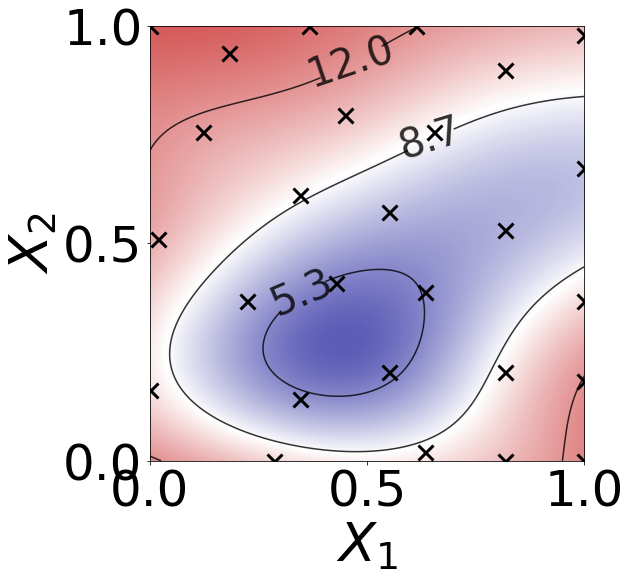

In [42]:
# In[22]:
from matplotlib.colors import LinearSegmentedColormap
#数据可视化

num_restarts = 10

# 初始化模型
input_dim = len(X[0])
    
ker = GPy.kern.Matern52(input_dim = input_dim, ARD = True)#

ker.lengthscale.constrain_bounded(0.01, 10) #lengthscale决定着点与点之间的相互作用程度
ker.variance.constrain_bounded(1e-2, 10000.0) #方差
    
model_gpy = GPRegression(X, Y, ker)
model_gpy.optimize_restarts(num_restarts=num_restarts,verbose =False, messages=False)
emukit_model = GPyModelWrapper(model_gpy)
        
        
        
space = ParameterSpace([ContinuousParameter('x', 0, 1),
                        ContinuousParameter('y', 0, 1)])


x = np.linspace(space.parameters[0].min, space.parameters[0].max, 200)[:, None]
y = np.linspace(space.parameters[0].min, space.parameters[0].max, 200)[:, None]
x_plot, y_plot = np.meshgrid(x, y)

Z, var_plot = emukit_model.predict(np.c_[x_plot.ravel(), y_plot.ravel()])

Z = Z.reshape(x_plot.shape)
# Z = Z.ravel()
# Z = -ei_acquisition_nom+1

x_points = X[:, 0]
y_points = X[:, 1]


plt.figure(figsize=(12, 8))

marker_color = (63/255, 101/255, 97/255)

# plt.plot(x_points, y_points, "o", markersize=12, color="r",label="Observations")
# plt.plot(x_points, y_points,"o", markersize=15, markerfacecolor='none', color="r", markeredgewidth=3, label="Observations")
plt.plot(x_points, y_points,"x", markersize=15, markerfacecolor='none', color="black", markeredgewidth=3, label="Observations")
# plt.plot(x_points, y_points, "ro", markersize=6, label="Observations")


fontsize=50
alpha = 0.8
# plt.legend(loc=2, prop={'size': fontsize})

colors = [(0.2, 0.2, 0.65), (1, 1, 1), (0.8, 0.2, 0.2)]  # 从深紫色到白色再到红褐色
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# cmap='Blues_r'
plt.imshow(Z, extent=[0, 1, 0, 1], origin='lower', cmap=cmap, alpha=alpha)
# plt.imshow(Z, extent=[0, 1, 0, 1], origin='lower', cmap='RdGy_r')
# plt.imshow(Z, extent=[0, 1, 0, 1], origin='lower', cmap=cmap, alpha=0.5)

# colorbar = plt.colorbar()
# colorbar.ax.tick_params(labelsize=fontsize)
# plt.rc('font', size=fontsize) 
contour_lines = plt.contour(x_plot, y_plot, Z, levels=np.linspace(2, 12, 4), colors='black', alpha=alpha)
plt.clabel(contour_lines, fontsize=fontsize*0.8, colors='black', inline=True, fmt='%.1f')




# 修改 x 轴和 y 轴的标签
plt.xlabel('$X_1$', fontsize=fontsize+4)
plt.ylabel('$X_2$', fontsize=fontsize+4)

# 设置 x 轴的刻度标签字体大小为 12
plt.xticks([0, 0.5, 1], fontsize=fontsize)

# 设置 y 轴的刻度标签字体大小为 12
plt.yticks([0, 0.5, 1], fontsize=fontsize)

# plt.gca().axes.get_xaxis().set_visible(False)

# plt.gca().axes.get_yaxis().set_visible(False)

plt.show()


# 相关代码


In [32]:
import numpy as np
from collections import Counter

def find_duplicate_rows(X):
    Z = X
    # 将数组中的每一行表示为元组，并将这些元组存储在列表中
    row_tuples = [tuple(row) for row in Z]

    # 使用Python的collections.Counter来计算元组的出现次数
    row_counts = Counter(row_tuples)

    # 初始化总的重复次数
    total_duplicate_count = 0

    # 创建一个集合来存储已经计数过的行
    counted_rows = set()

    # 打印重复行的行号（索引）和它们的重复次数，并计算总的重复次数
    for index, row in enumerate(Z):
        row_tuple = tuple(row)
        if row_tuple not in counted_rows:
            count = row_counts[row_tuple]
            if count > 1:
                duplicate_indices = [i for i, r in enumerate(Z) if tuple(r) == row_tuple]
                print(f"行 {index} 重复了 {count} 次，与行 {duplicate_indices} 重复")
                total_duplicate_count += count
            counted_rows.add(row_tuple)  # 将该行添加到已计数的行集合中

    # 打印总的重复次数
    print(f"总的重复次数为: {total_duplicate_count}")

    # 初始化总的不同重复行数
    total_unique_duplicate_count = 0

    # 创建一个集合来存储已经计数过的行
    counted_rows = set()

    # 计算不同的重复行数
    for row_tuple, count in row_counts.items():
        if count > 1:
            total_unique_duplicate_count += 1
            counted_rows.add(row_tuple)

    # 打印总的不同重复行数
    print(f"总的不同重复行数为: {total_unique_duplicate_count}")

print(X.shape)
find_duplicate_rows(X)

(52, 9)
总的重复次数为: 0
总的不同重复行数为: 0


# # 模型预测二维映射

In [53]:
# In[22]:
from matplotlib.colors import LinearSegmentedColormap
#数据可视化

num_restarts = 10
model_gpy = GPRegression(X, Y, ker)
model_gpy.optimize_restarts(num_restarts=num_restarts,verbose =False, messages=False)
emukit_model = GPyModelWrapper(model_gpy)
        

num_columns = X_all.shape[1]
parameter_space = ParameterSpace([ContinuousParameter(f'x{i+1}', 0, 1) for i in range(num_columns)])
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df.iloc[:,:-1].columns

In [54]:
## Generate a 2D grid for Contour plot
ind1 = 0
ind2 = 1
n_steps =21
x1x2y_pred, x1x2y_uncer =[[],[]]
for x1 in np.linspace(0, 1, n_steps):
    for x2 in np.linspace(0, 1, n_steps):
        x_temp = np.copy(x_sampled)
        x_temp[:,ind1] = x1
        x_temp[:,ind2] = x2
        y_pred, y_uncer = emukit_model.predict(x_temp)
        y_pred = y_pred
        x1_org = np.array(x_denormalizer(x_temp, var_array))[0,ind1]
        x2_org = np.array(x_denormalizer(x_temp, var_array))[0,ind2]
        x1x2y_pred.append([x1_org, x2_org, np.max(y_pred), np.mean(y_pred), np.min(y_pred)])
        x1x2y_uncer.append([x1_org, x2_org, np.max(np.sqrt(y_uncer)), np.mean(np.sqrt(y_uncer)), np.min(np.sqrt(y_uncer))])

x1 = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
x2 = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)

y_pred_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
y_pred_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
y_pred_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)


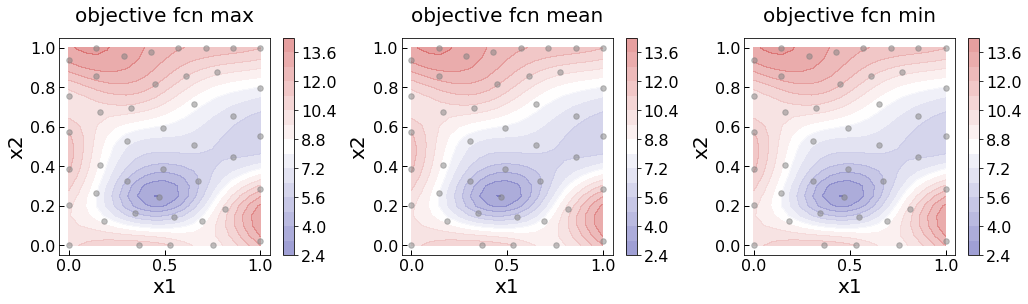

In [55]:
fs = 20
title_pad = 16

## Contour for Prediction Efficiency Mean
fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)

for ax,  y in zip(axes, [y_pred_max, y_pred_mean, y_pred_min]):

    colors = [(0.2, 0.2, 0.65), (1, 1, 1), (0.8, 0.2, 0.2)]  # 从深紫色到白色再到红褐色
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    c_plt1 = ax.contourf(x1, x2, y, levels=15, extent=[0, 1, 0, 1], origin='lower', cmap=cmap, alpha=0.5)
    cbar = fig.colorbar(c_plt1, ax= ax)
    cbar.ax.tick_params(labelsize=fs*0.8)
    ax.scatter( X[:, ind1],   # np.array(x_denormalizer(X, var_array)
                X[:, ind2], 
               s = 30, facecolors='gray', alpha = 0.5, edgecolor = 'gray')
    
    ax.set_xlabel(str(x_columns[ind1]),fontsize =  fs)
    ax.set_ylabel(str(x_columns[ind2]),fontsize =  fs)

    x1_delta = (np.max(x1)-np.min(x1))*0.05
    x2_delta = (np.max(x2)-np.min(x2))*0.05
    ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
    ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
    ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5

    #ax.grid(True, linestyle='-.')

axes[0].set_title('objective fcn max', pad = title_pad,fontsize =  fs)
axes[1].set_title('objective fcn mean', pad = title_pad,fontsize =  fs)
axes[2].set_title('objective fcn min', pad = title_pad,fontsize =  fs)

plt.subplots_adjust(wspace = 0.3)
plt.show()

In [56]:
print(X.shape,Y.shape,spearman_mean.shape)

(43, 2) (43, 1) (41,)
